In [1]:
import time

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/IS4303/notebooks/new_cleaned

Mounted at /content/drive
/content/drive/MyDrive/IS4303/notebooks/new_cleaned


# Helpers

In [3]:
X_train = pd.read_csv('./5X_train.csv')
X_test = pd.read_csv('./4X_test.csv')
y_train = pd.read_csv('./5y_train.csv')
y_test = pd.read_csv('./4y_test.csv')
y_train = y_train['is_canceled']
y_test = y_test['is_canceled']

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
def plot_preds(preds, probas, truth):
    auc_score = roc_auc_score(truth, probas)
    prec = precision_score(truth, preds)
    rec = recall_score(truth, preds)
    f1 = f1_score(truth, preds)
    print(f"AUC: {auc_score:.2f}\n")
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f"F1: {f1:.2f}\n")

    fpr, tpr, thresholds = roc_curve(truth, probas)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

# Model

In [5]:
class SubgroupAwareModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_clusters=2, n_components=2, base_classifier=None, subgroup_classifier=None):
        self.n_clusters = n_clusters
        self.n_components = n_components
        self.base_classifier = base_classifier or XGBClassifier() # maybe add our xgb tuned params
        self.subgroup_classifier = subgroup_classifier or XGBClassifier()
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=self.n_components)
        self.cluster_model = KMeans(n_clusters=self.n_clusters, n_init='auto')

    def fit(self, X, y):
        X_pca = self.pca.fit_transform(X) # to fight the curse of dimensionality with clustering
        self.cluster_model.fit(X_pca)
        cluster_labels = self.cluster_model.labels_

        self.base_classifier.fit(X, y)

        self.subgroup_classifiers = []
        for i in range(self.n_clusters):
            subgroup_X_train = X[cluster_labels[X.index] == i]
            subgroup_y_train = y.loc[subgroup_X_train.index]

            if len(subgroup_X_train) == 0 or len(np.unique(subgroup_y_train)) < 2:
                continue

            subgroup_classifier = self.subgroup_classifier.__class__()
            subgroup_classifier.fit(subgroup_X_train, subgroup_y_train)
            self.subgroup_classifiers.append(subgroup_classifier)

        return self

    def predict_proba(self, X):
      X_pca = self.pca.transform(X)
      cluster_labels = self.cluster_model.predict(X_pca)

      base_proba = self.base_classifier.predict_proba(X)

      subgroup_probas = np.zeros_like(base_proba)
      for i, subgroup_classifier in enumerate(self.subgroup_classifiers):
          mask = (cluster_labels == i)
          
          if np.sum(mask) > 0: 
              subgroup_proba = subgroup_classifier.predict_proba(X[mask])
              subgroup_probas[mask] = subgroup_proba
          else:
              subgroup_probas[mask] = base_proba[mask]

      ensemble_proba = np.mean(np.stack([base_proba, subgroup_probas]), axis=0)
      return ensemble_proba

    def predict(self, X):
        ensemble_proba = self.predict_proba(X)
        predictions = np.argmax(ensemble_proba, axis=1)
        return predictions

# Hyperparamter tuning

Manual k-fold grid search

In [6]:
parameters = {
    'n_clusters': [2, 4, 6],
    'n_components': [2, 7, 15],
}

best_params_f1 = {
    'n_clusters': None,
    'n_components': None
}

best_params_auc = {
    'n_clusters': None,
    'n_components': None
}

best_f1 = -1
best_auc = -1

k_folds = 3
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

fits = len(parameters['n_clusters']) * len(parameters['n_components']) * k_folds
print(f'Starting with {fits} fits')

i = 1
for n_clusters in parameters['n_clusters']:
  for n_components in parameters['n_components']:
      start_time = time.time()
      print(f'Fitting: {i}/{fits}\tn_clusters: {n_clusters}\tn_components: {n_components}')
      i = i + 1

      model = SubgroupAwareModel(n_clusters=n_clusters, n_components=n_components)
      f1_scores = []
      auc_scores = []

      for train_idx, val_idx in cv.split(X_train, y_train):
          X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
          y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

          X_train_fold = X_train_fold.reset_index(drop=True)
          X_val_fold = X_val_fold.reset_index(drop=True)
          y_train_fold = y_train_fold.reset_index(drop=True)
          y_val_fold = y_val_fold.reset_index(drop=True)

          model.fit(X_train_fold, y_train_fold)
          y_pred = model.predict(X_val_fold)
          y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
          f1 = f1_score(y_val_fold, y_pred, average='weighted')
          auc = roc_auc_score(y_val_fold, y_pred_proba, average='weighted')
          f1_scores.append(f1)
          auc_scores.append(auc)

      avg_f1 = np.mean(f1_scores)
      avg_auc = np.mean(auc_scores)

      if avg_f1 > best_f1:
          best_params_f1 = {
              'n_clusters': n_clusters,
              'n_components': n_components
          }
          best_f1 = avg_f1

      if avg_auc > best_auc:
          best_params_auc = {
              'n_clusters': n_clusters,
              'n_components': n_components
          }
          best_auc = avg_auc
      time_taken = time.time() - start_time

      print(f'Time taken: {time_taken:.2f} seconds.\tAUC: {avg_auc:.2f}\tF1: {avg_f1:.2f}\n')

print(f'\nBest params F1: {best_params_f1}')
print(f'Best F1:\t{best_f1:.2f}\n')

print(f'Best params AUC: {best_params_auc}')
print(f'Best AUC:\t{best_auc:.2f}')

Starting with 27 fits
Fitting: 1/27	n_clusters: 2	n_components: 2
Time taken: 861.96 seconds.	AUC: 0.89	F1: 0.81

Fitting: 2/27	n_clusters: 2	n_components: 7
Time taken: 871.72 seconds.	AUC: 0.89	F1: 0.81

Fitting: 3/27	n_clusters: 2	n_components: 15
Time taken: 873.91 seconds.	AUC: 0.89	F1: 0.81

Fitting: 4/27	n_clusters: 4	n_components: 2
Time taken: 868.43 seconds.	AUC: 0.90	F1: 0.82

Fitting: 5/27	n_clusters: 4	n_components: 7
Time taken: 868.39 seconds.	AUC: 0.90	F1: 0.82

Fitting: 6/27	n_clusters: 4	n_components: 15
Time taken: 872.93 seconds.	AUC: 0.89	F1: 0.82

Fitting: 7/27	n_clusters: 6	n_components: 2
Time taken: 864.72 seconds.	AUC: 0.90	F1: 0.82

Fitting: 8/27	n_clusters: 6	n_components: 7
Time taken: 868.30 seconds.	AUC: 0.88	F1: 0.81

Fitting: 9/27	n_clusters: 6	n_components: 15
Time taken: 867.00 seconds.	AUC: 0.89	F1: 0.81


Best params F1: {'n_clusters': 6, 'n_components': 2}
Best F1:	0.82

Best params AUC: {'n_clusters': 6, 'n_components': 2}
Best AUC:	0.90


In [6]:
best_params = {'n_clusters': 6, 'n_components': 2}

clf = SubgroupAwareModel(**best_params)
clf.fit(X_train, y_train)

SubgroupAwareModel(base_classifier=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rat...
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))

AUC: 0.84

Precision: 0.61
Recall: 0.70
F1: 0.65



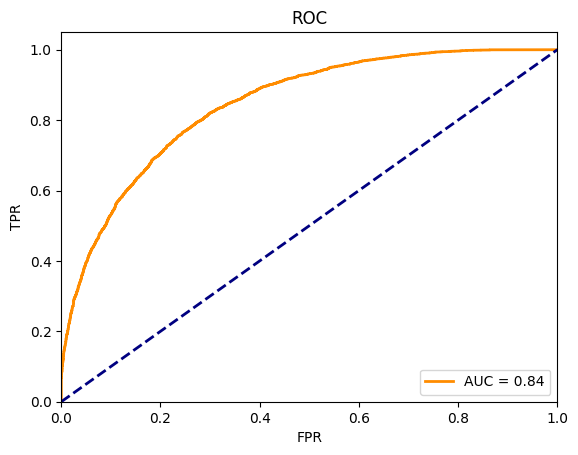

In [7]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
plot_preds(y_pred, y_pred_proba, y_test)

In [8]:
# choosing 4 because 4 did good with 2 or 7 components, and did better upon this manual test
# also issues with data fragmentation
best_params = {'n_clusters': 4, 'n_components': 2} 

clf = SubgroupAwareModel(**best_params)
clf.fit(X_train, y_train)

SubgroupAwareModel(base_classifier=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rat...
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))

AUC: 0.85

Precision: 0.62
Recall: 0.72
F1: 0.66



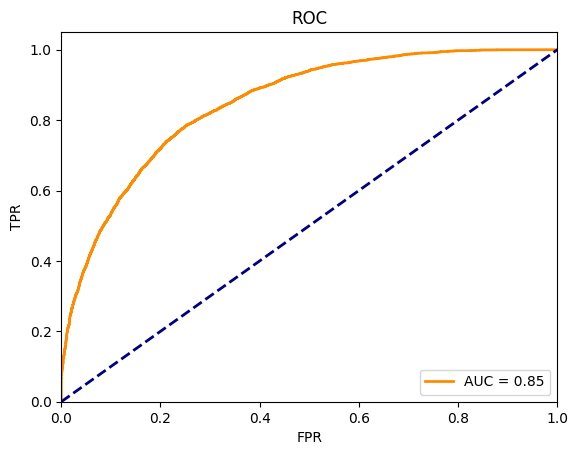

In [9]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
plot_preds(y_pred, y_pred_proba, y_test)